<a href="https://colab.research.google.com/github/flash-berry/MachineLearning-2025/blob/main/HW_2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашнее задание 2**

**Выполнил студент:** Пышный Артём

**Доступ к датасету:** https://www.kaggle.com/datasets/jockeroika/clouds-photos



---



**Описание датасета:**

Этот набор данных состоит из 961 маркированных изображений облаков, сгруппированных в 7 категорий в зависимости от типов облаков.

Тип данных: Фотографические изображения (JPG).

Структура: изображения хранятся в подпапках, где каждая папка соответствует типу облака.

Классы: высокие кучевые, кучевые, усикообразные, слоисто-кучевые, ясное небо, слоистообразные, кучево-дождевые.

Баланс: набор данных несбалансирован, некоторые классы (например, кучево-дождевые) представлены недостаточно по сравнению с другими (высокие кучево-образные).

In [22]:
!pip install gdown

In [23]:
import kagglehub
import os
import zipfile
import copy
import glob
from PIL import Image
from tqdm import tqdm
import gdown

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = kagglehub.dataset_download("jockeroika/clouds-photos")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'clouds-photos' dataset.
Path to dataset files: /kaggle/input/clouds-photos


In [3]:
for root, dirs, files in os.walk(path):
    print(root, len(files), 'файлов')

/kaggle/input/clouds-photos 0 файлов
/kaggle/input/clouds-photos/clouds_train 0 файлов
/kaggle/input/clouds-photos/clouds_train/high cumuliform clouds 133 файлов
/kaggle/input/clouds-photos/clouds_train/cumulus clouds 91 файлов
/kaggle/input/clouds-photos/clouds_train/cirriform clouds 66 файлов
/kaggle/input/clouds-photos/clouds_train/stratiform clouds 49 файлов
/kaggle/input/clouds-photos/clouds_train/stratocumulus clouds 61 файлов
/kaggle/input/clouds-photos/clouds_train/cumulonimbus clouds 14 файлов
/kaggle/input/clouds-photos/clouds_train/clear sky 60 файлов
/kaggle/input/clouds-photos/clouds_test 0 файлов
/kaggle/input/clouds-photos/clouds_test/high cumuliform clouds 103 файлов
/kaggle/input/clouds-photos/clouds_test/cumulus clouds 120 файлов
/kaggle/input/clouds-photos/clouds_test/cirriform clouds 77 файлов
/kaggle/input/clouds-photos/clouds_test/stratiform clouds 40 файлов
/kaggle/input/clouds-photos/clouds_test/stratocumulus clouds 71 файлов
/kaggle/input/clouds-photos/clouds_t

In [4]:
train_dir = os.path.join(path, "clouds_train")
test_dir = os.path.join(path, "clouds_test")

In [5]:
batch_size = 32
learning_rate = 1e-4
num_workers = 2
num_epochs = 5
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform = test_transforms)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

print(f"Классы: {train_dataset.classes}")
print(f"Обучающих изображения: {len(train_dataset)}, тестовых изображений: {len(test_dataset)}")

Классы: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']
Обучающих изображения: 474, тестовых изображений: 486


In [7]:
class EarlyStopping:
    def __init__(self, patience = 3):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model_wts = None
        self.early_stop = False

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform = None):
        self.paths = sorted(glob.glob(os.path.join(image_dir, "*")))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def generate_pseudo_labels(model, unlabeled_loader, threshold = 0.9):
    model.eval()
    pseudo_images = []
    pseudo_labels = []

    with torch.no_grad():
        for images in unlabeled_loader:
            images = images.to(device)
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim = 1)
            confidences, preds = torch.max(probs, dim=1)

            mask = confidences > threshold
            pseudo_images.append(images[mask].cpu())
            pseudo_labels.append(preds[mask].cpu())

    if len(pseudo_images) == 0:
        print("Нет примеров, которые прошли порог уверенности.")
        return None

    pseudo_images = torch.cat(pseudo_images)
    pseudo_labels = torch.cat(pseudo_labels)

    print(f"Сгенерировано {len(pseudo_labels)} псевдолейблов.")

    return pseudo_images, pseudo_labels


def create_clean_model():
    model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    num_classes = len(train_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    return model

def paint_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix - Cloud Classification")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def train_one_epoch(model, loader, optimizer, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc = f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_model(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total, y_true, y_pred


def train_model(model, train_loader, test_loader, epochs_settings):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for idx_set, settings in enumerate(epochs_settings):
        print(f"\n\t Этап: {idx_set + 1} / {len(epochs_settings)} | Размораживаем: {settings['unfreeze']} | LR = {settings['lr']}")

        train_dataset.transform = settings["transform"]

        for param in model.parameters():
            param.requires_grad = False

        for name, param in model.named_parameters():
            if any(u in name for u in settings["unfreeze"]):
                param.requires_grad = True

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = settings["lr"])
        scheduler = StepLR(optimizer, step_size = 3, gamma = 0.5)
        early_stopper = EarlyStopping(patience = patience)

        for epoch in range(settings["num_epochs"]):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, epoch, settings["num_epochs"])
            val_loss, val_acc, _, _ = eval_model(model, test_loader)
            scheduler.step()

            print(f"Эпоха {epoch+1}/{settings["num_epochs"]}: "
                  f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                  f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

            early_stopper.step(val_loss, model)
            if early_stopper.early_stop:
                print("Early stopping на этом этапе!")
                break

        if early_stopper.best_model_wts is not None:
            model.load_state_dict(early_stopper.best_model_wts)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    return model

In [8]:
model = create_clean_model()
criterion = nn.CrossEntropyLoss()


	 Этап: 1 / 1 | Размораживаем: ['fc'] | LR = 0.001


Epoch 1/25: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Эпоха 1/25: Train Loss=1.5857, Acc=0.4599 | Val Loss=1.4270, Acc=0.6440


Epoch 2/25: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Эпоха 2/25: Train Loss=0.9753, Acc=0.7932 | Val Loss=0.9466, Acc=0.8436


Epoch 3/25: 100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Эпоха 3/25: Train Loss=0.6950, Acc=0.8797 | Val Loss=0.6731, Acc=0.8519


Epoch 4/25: 100%|██████████| 15/15 [00:02<00:00,  7.37it/s]


Эпоха 4/25: Train Loss=0.5641, Acc=0.8861 | Val Loss=0.5947, Acc=0.8724


Epoch 5/25: 100%|██████████| 15/15 [00:02<00:00,  7.32it/s]


Эпоха 5/25: Train Loss=0.5384, Acc=0.8755 | Val Loss=0.5458, Acc=0.8704


Epoch 6/25: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s]


Эпоха 6/25: Train Loss=0.4603, Acc=0.9156 | Val Loss=0.5261, Acc=0.8724


Epoch 7/25: 100%|██████████| 15/15 [00:02<00:00,  7.36it/s]


Эпоха 7/25: Train Loss=0.4222, Acc=0.9198 | Val Loss=0.4952, Acc=0.8745


Epoch 8/25: 100%|██████████| 15/15 [00:02<00:00,  7.49it/s]


Эпоха 8/25: Train Loss=0.4357, Acc=0.9072 | Val Loss=0.4920, Acc=0.8724


Epoch 9/25: 100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


Эпоха 9/25: Train Loss=0.4005, Acc=0.9241 | Val Loss=0.4739, Acc=0.8765


Epoch 10/25: 100%|██████████| 15/15 [00:01<00:00,  7.67it/s]


Эпоха 10/25: Train Loss=0.4093, Acc=0.9135 | Val Loss=0.4707, Acc=0.8765


Epoch 11/25: 100%|██████████| 15/15 [00:01<00:00,  7.64it/s]


Эпоха 11/25: Train Loss=0.4348, Acc=0.9114 | Val Loss=0.4771, Acc=0.8786


Epoch 12/25: 100%|██████████| 15/15 [00:02<00:00,  7.40it/s]


Эпоха 12/25: Train Loss=0.3847, Acc=0.9114 | Val Loss=0.4672, Acc=0.8724


Epoch 13/25: 100%|██████████| 15/15 [00:02<00:00,  7.49it/s]


Эпоха 13/25: Train Loss=0.3765, Acc=0.9283 | Val Loss=0.4605, Acc=0.8786


Epoch 14/25: 100%|██████████| 15/15 [00:01<00:00,  7.53it/s]


Эпоха 14/25: Train Loss=0.3702, Acc=0.9388 | Val Loss=0.4657, Acc=0.8765


Epoch 15/25: 100%|██████████| 15/15 [00:01<00:00,  7.60it/s]


Эпоха 15/25: Train Loss=0.3734, Acc=0.9198 | Val Loss=0.4535, Acc=0.8745


Epoch 16/25: 100%|██████████| 15/15 [00:01<00:00,  7.62it/s]


Эпоха 16/25: Train Loss=0.3894, Acc=0.9346 | Val Loss=0.4504, Acc=0.8786


Epoch 17/25: 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


Эпоха 17/25: Train Loss=0.3527, Acc=0.9451 | Val Loss=0.4518, Acc=0.8745


Epoch 18/25: 100%|██████████| 15/15 [00:01<00:00,  7.62it/s]


Эпоха 18/25: Train Loss=0.3648, Acc=0.9283 | Val Loss=0.4434, Acc=0.8827


Epoch 19/25: 100%|██████████| 15/15 [00:02<00:00,  7.48it/s]


Эпоха 19/25: Train Loss=0.3629, Acc=0.9409 | Val Loss=0.4456, Acc=0.8807


Epoch 20/25: 100%|██████████| 15/15 [00:01<00:00,  7.53it/s]


Эпоха 20/25: Train Loss=0.3541, Acc=0.9304 | Val Loss=0.4465, Acc=0.8786


Epoch 21/25: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


Эпоха 21/25: Train Loss=0.3659, Acc=0.9388 | Val Loss=0.4504, Acc=0.8807
Early stopping на этом этапе!
Test loss: 0.4434, Test accuracy: 88.2716


<Figure size 800x600 with 0 Axes>

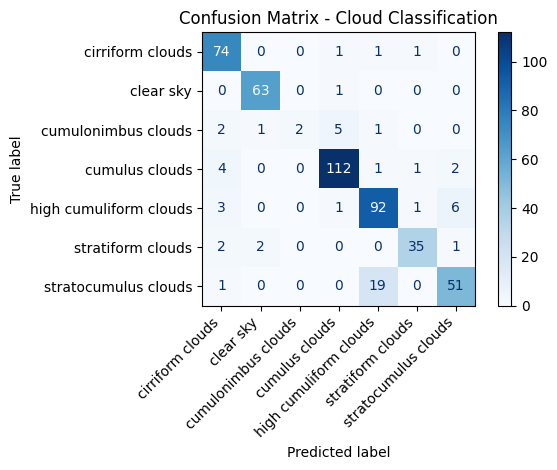

In [9]:
epochs_settings = [
    {"unfreeze": ["fc"], "lr": 1e-3, "transform": train_transforms, "num_epochs": 25}
]

model = train_model(model, train_loader, test_loader, epochs_settings)

test_loss, test_acc, y_true, y_pred = eval_model(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {100 * test_acc:.4f}")

paint_confusion_matrix(y_true, y_pred)

**Вывод:** модель хорошо распознаёт популярные классы и плохо справляется с маленькими классами (Cumulonimbus clouds, Stratocumulus clouds), то есть модель смещена в пользу популярных классов из-за дисбаланса в обучающей выборке.

# Добавим разморозку слоёв

In [10]:
model = create_clean_model()


	 Этап: 1 / 5 | Размораживаем: ['fc'] | LR = 0.001


Epoch 1/5: 100%|██████████| 15/15 [00:02<00:00,  7.34it/s]


Эпоха 1/5: Train Loss=1.5847, Acc=0.5359 | Val Loss=1.4653, Acc=0.5947


Epoch 2/5: 100%|██████████| 15/15 [00:01<00:00,  7.67it/s]


Эпоха 2/5: Train Loss=0.9955, Acc=0.7468 | Val Loss=0.9673, Acc=0.8086


Epoch 3/5: 100%|██████████| 15/15 [00:01<00:00,  7.58it/s]


Эпоха 3/5: Train Loss=0.7092, Acc=0.8523 | Val Loss=0.6867, Acc=0.8354


Epoch 4/5: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Эпоха 4/5: Train Loss=0.6027, Acc=0.8692 | Val Loss=0.5988, Acc=0.8621


Epoch 5/5: 100%|██████████| 15/15 [00:02<00:00,  7.49it/s]


Эпоха 5/5: Train Loss=0.5471, Acc=0.8671 | Val Loss=0.5670, Acc=0.8601

	 Этап: 2 / 5 | Размораживаем: ['layer4', 'fc'] | LR = 0.0005


Epoch 1/5: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]


Эпоха 1/5: Train Loss=0.3193, Acc=0.9030 | Val Loss=0.2623, Acc=0.9136


Epoch 2/5: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]


Эпоха 2/5: Train Loss=0.0504, Acc=0.9895 | Val Loss=0.2219, Acc=0.9362


Epoch 3/5: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


Эпоха 3/5: Train Loss=0.0284, Acc=0.9958 | Val Loss=0.2691, Acc=0.9259


Epoch 4/5: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


Эпоха 4/5: Train Loss=0.0229, Acc=0.9916 | Val Loss=0.2283, Acc=0.9362


Epoch 5/5: 100%|██████████| 15/15 [00:02<00:00,  5.36it/s]


Эпоха 5/5: Train Loss=0.0093, Acc=0.9979 | Val Loss=0.2160, Acc=0.9383

	 Этап: 3 / 5 | Размораживаем: ['layer3', 'layer4', 'fc'] | LR = 0.0001


Epoch 1/5: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


Эпоха 1/5: Train Loss=0.0120, Acc=0.9979 | Val Loss=0.2208, Acc=0.9424


Epoch 2/5: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Эпоха 2/5: Train Loss=0.0048, Acc=1.0000 | Val Loss=0.2157, Acc=0.9342


Epoch 3/5: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Эпоха 3/5: Train Loss=0.0024, Acc=1.0000 | Val Loss=0.2158, Acc=0.9403


Epoch 4/5: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Эпоха 4/5: Train Loss=0.0027, Acc=1.0000 | Val Loss=0.2098, Acc=0.9403


Epoch 5/5: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


Эпоха 5/5: Train Loss=0.0044, Acc=0.9979 | Val Loss=0.2058, Acc=0.9403

	 Этап: 4 / 5 | Размораживаем: ['layer2', 'layer3', 'layer4', 'fc'] | LR = 5e-05


Epoch 1/5: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Эпоха 1/5: Train Loss=0.0075, Acc=0.9979 | Val Loss=0.1844, Acc=0.9424


Epoch 2/5: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Эпоха 2/5: Train Loss=0.0006, Acc=1.0000 | Val Loss=0.1927, Acc=0.9424


Epoch 3/5: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Эпоха 3/5: Train Loss=0.0013, Acc=1.0000 | Val Loss=0.2058, Acc=0.9444


Epoch 4/5: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Эпоха 4/5: Train Loss=0.0010, Acc=1.0000 | Val Loss=0.2130, Acc=0.9383
Early stopping на этом этапе!

	 Этап: 5 / 5 | Размораживаем: ['layer1', 'layer2', 'layer3', 'layer4', 'fc'] | LR = 1e-05


Epoch 1/5: 100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


Эпоха 1/5: Train Loss=0.0033, Acc=0.9979 | Val Loss=0.1887, Acc=0.9424


Epoch 2/5: 100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


Эпоха 2/5: Train Loss=0.0009, Acc=1.0000 | Val Loss=0.1968, Acc=0.9424


Epoch 3/5: 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


Эпоха 3/5: Train Loss=0.0005, Acc=1.0000 | Val Loss=0.1996, Acc=0.9424


Epoch 4/5: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


Эпоха 4/5: Train Loss=0.0016, Acc=1.0000 | Val Loss=0.2005, Acc=0.9403
Early stopping на этом этапе!
Test loss: 0.2058, Test accuracy: 94.0329


<Figure size 800x600 with 0 Axes>

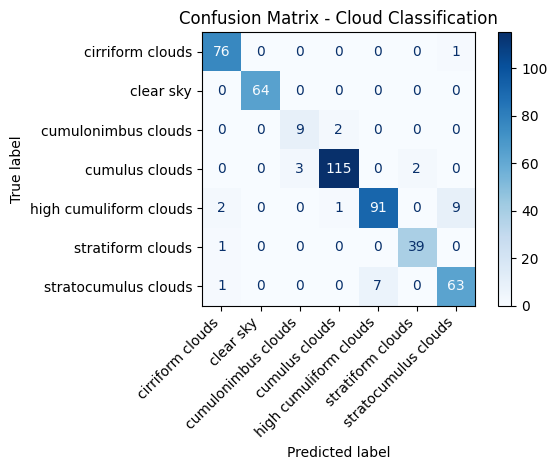

In [11]:
epochs_settings = [
        {"unfreeze": ["fc"], "lr": 1e-3, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer4", "fc"], "lr": 5e-4, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer3", "layer4", "fc"], "lr": 1e-4, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer2", "layer3", "layer4", "fc"], "lr": 5e-5, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer1", "layer2", "layer3", "layer4", "fc"], "lr": 1e-5, "transform": train_transforms, "num_epochs": 5},
    ]

model = train_model(model, train_loader, test_loader, epochs_settings)

test_loss, test_acc, y_true, y_pred = eval_model(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {100 * test_acc:.4f}")

paint_confusion_matrix(y_true, y_pred)

**Вывод:** обучение с постепенной разморозкой слоёв дало буст точности с 88.27% до 94.03%. Модель не потеряла обобщающую способность на популярных классах и вместе с тем увеличила предсказательную способность для малых классов.



*   В классе Cumulonumbus clouds True Positive с 2 повысилось до 9
*   В классе Stratocumulus clouds True Positive с 51 повысилось до 63
*   В классе Stratiform clouds True Positive с 35 повысилось до 39



# Добавим аугментацию и итеративное обучение на исходных/аугментированных данных

In [12]:
model = create_clean_model()

In [13]:
aug_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


	 Этап: 1 / 5 | Размораживаем: ['fc'] | LR = 0.001


Epoch 1/5: 100%|██████████| 15/15 [00:01<00:00,  7.51it/s]


Эпоха 1/5: Train Loss=1.5265, Acc=0.5295 | Val Loss=1.4235, Acc=0.6728


Epoch 2/5: 100%|██████████| 15/15 [00:01<00:00,  7.62it/s]


Эпоха 2/5: Train Loss=0.9843, Acc=0.8017 | Val Loss=0.9536, Acc=0.8086


Epoch 3/5: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


Эпоха 3/5: Train Loss=0.6873, Acc=0.8734 | Val Loss=0.6694, Acc=0.8498


Epoch 4/5: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s]


Эпоха 4/5: Train Loss=0.5646, Acc=0.8650 | Val Loss=0.5912, Acc=0.8724


Epoch 5/5: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s]


Эпоха 5/5: Train Loss=0.4945, Acc=0.9030 | Val Loss=0.5520, Acc=0.8683

	 Этап: 2 / 5 | Размораживаем: ['layer4', 'fc'] | LR = 0.0005


Epoch 1/5: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Эпоха 1/5: Train Loss=0.5703, Acc=0.8186 | Val Loss=0.3658, Acc=0.8786


Epoch 2/5: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Эпоха 2/5: Train Loss=0.3109, Acc=0.8924 | Val Loss=0.2505, Acc=0.8971


Epoch 3/5: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Эпоха 3/5: Train Loss=0.2216, Acc=0.9198 | Val Loss=0.2459, Acc=0.9053


Epoch 4/5: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


Эпоха 4/5: Train Loss=0.1258, Acc=0.9578 | Val Loss=0.2298, Acc=0.9115


Epoch 5/5: 100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


Эпоха 5/5: Train Loss=0.1157, Acc=0.9662 | Val Loss=0.2856, Acc=0.9033

	 Этап: 3 / 5 | Размораживаем: ['layer3', 'layer4', 'fc'] | LR = 0.0001


Epoch 1/5: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Эпоха 1/5: Train Loss=0.0979, Acc=0.9684 | Val Loss=0.1723, Acc=0.9342


Epoch 2/5: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Эпоха 2/5: Train Loss=0.0434, Acc=0.9852 | Val Loss=0.1881, Acc=0.9362


Epoch 3/5: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Эпоха 3/5: Train Loss=0.0225, Acc=0.9958 | Val Loss=0.1823, Acc=0.9403


Epoch 4/5: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Эпоха 4/5: Train Loss=0.0149, Acc=0.9979 | Val Loss=0.1757, Acc=0.9444
Early stopping на этом этапе!

	 Этап: 4 / 5 | Размораживаем: ['layer2', 'layer3', 'layer4', 'fc'] | LR = 5e-05


Epoch 1/5: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Эпоха 1/5: Train Loss=0.1190, Acc=0.9705 | Val Loss=0.2168, Acc=0.9259


Epoch 2/5: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Эпоха 2/5: Train Loss=0.0929, Acc=0.9662 | Val Loss=0.1875, Acc=0.9239


Epoch 3/5: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Эпоха 3/5: Train Loss=0.0763, Acc=0.9684 | Val Loss=0.1751, Acc=0.9300


Epoch 4/5: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Эпоха 4/5: Train Loss=0.0788, Acc=0.9705 | Val Loss=0.1755, Acc=0.9321


Epoch 5/5: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Эпоха 5/5: Train Loss=0.0455, Acc=0.9852 | Val Loss=0.1897, Acc=0.9300

	 Этап: 5 / 5 | Размораживаем: ['layer1', 'layer2', 'layer3', 'layer4', 'fc'] | LR = 1e-05


Epoch 1/5: 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


Эпоха 1/5: Train Loss=0.0315, Acc=0.9895 | Val Loss=0.1381, Acc=0.9444


Epoch 2/5: 100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


Эпоха 2/5: Train Loss=0.0190, Acc=0.9937 | Val Loss=0.1519, Acc=0.9465


Epoch 3/5: 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


Эпоха 3/5: Train Loss=0.0560, Acc=0.9810 | Val Loss=0.1689, Acc=0.9342


Epoch 4/5: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Эпоха 4/5: Train Loss=0.0202, Acc=0.9979 | Val Loss=0.1689, Acc=0.9362
Early stopping на этом этапе!
Test loss: 0.1723, Test accuracy: 93.4156


<Figure size 800x600 with 0 Axes>

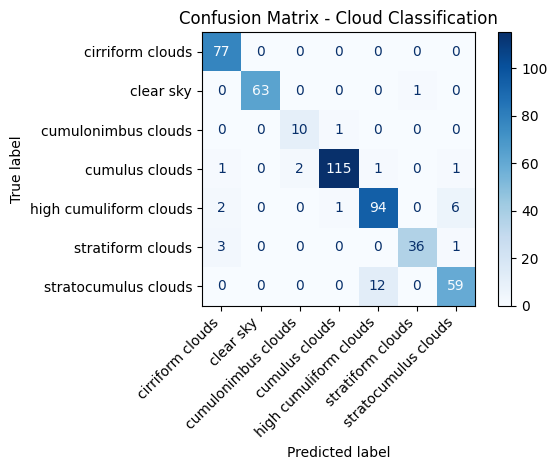

In [14]:
epochs_settings = [
        {"unfreeze": ["fc"], "lr": 1e-3, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer4", "fc"], "lr": 5e-4, "transform": aug_transforms, "num_epochs": 5},
        {"unfreeze": ["layer3", "layer4", "fc"], "lr": 1e-4, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer2", "layer3", "layer4", "fc"], "lr": 5e-5, "transform": aug_transforms, "num_epochs": 5},
        {"unfreeze": ["layer1", "layer2", "layer3", "layer4", "fc"], "lr": 1e-5, "transform": train_transforms, "num_epochs": 5}
    ]

model = train_model(model, train_loader, test_loader, epochs_settings)

test_loss, test_acc, y_true, y_pred = eval_model(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {100 * test_acc:.4f}")

paint_confusion_matrix(y_true, y_pred)

**Вывод:** итеративное обучение с аугментацией помогло ещё лучше различать самый малый класс (10 из 11 предсказаний правильные), но немного хуже стали предсказываться другие классы, что уменьшило точность с 94.03% до 93.41%

# Добавим псевдолейблинг


 В качестве неразмеченного датасета для псевдолейблинга использовался собранный вручную датасет облаков из 30 снимков

In [15]:
url = "https://drive.google.com/file/d/1eNPAJnsjlAQWpe0aWD14ti3b4jF9zeXr/view?usp=sharing"

file_id = url.split("/d/")[1].split("/")[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

zip_path = "/content/sky_unlabed.zip"
extract_dir = "/content/unlabed_dataset"

gdown.download(download_url, zip_path, quiet=False)

# === Распаковка ===
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

unlabeled_dataset = UnlabeledDataset(extract_dir, transform = train_transforms)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size = 32, shuffle = False, num_workers = num_workers)

pseudo_images, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold = 0.9)

if pseudo_images is not None:
    pseudo_labels = pseudo_labels.cpu().tolist()
    pseudo_dataset = [(img, int(label)) for img, label in zip(pseudo_images, pseudo_labels)]
    combined_dataset = ConcatDataset([train_dataset, pseudo_dataset])
    combined_loader = DataLoader(combined_dataset, batch_size = 32, shuffle = True, num_workers = num_workers)
else:
    combined_loader = train_loader

print(f"Обучающих изображения: {len(combined_dataset)}")

Сгенерировано 17 псевдолейблов.
Обучающих изображения: 491


In [17]:
model = create_clean_model()


	 Этап: 1 / 5 | Размораживаем: ['fc'] | LR = 0.001


Epoch 1/5: 100%|██████████| 16/16 [00:02<00:00,  7.94it/s]


Эпоха 1/5: Train Loss=1.5125, Acc=0.5092 | Val Loss=1.3983, Acc=0.6667


Epoch 2/5: 100%|██████████| 16/16 [00:02<00:00,  7.67it/s]


Эпоха 2/5: Train Loss=0.9616, Acc=0.7984 | Val Loss=0.9126, Acc=0.8457


Epoch 3/5: 100%|██████████| 16/16 [00:02<00:00,  7.91it/s]


Эпоха 3/5: Train Loss=0.6817, Acc=0.8697 | Val Loss=0.6466, Acc=0.8786


Epoch 4/5: 100%|██████████| 16/16 [00:02<00:00,  7.94it/s]


Эпоха 4/5: Train Loss=0.5701, Acc=0.8921 | Val Loss=0.5826, Acc=0.8704


Epoch 5/5: 100%|██████████| 16/16 [00:02<00:00,  7.66it/s]


Эпоха 5/5: Train Loss=0.4925, Acc=0.9084 | Val Loss=0.5372, Acc=0.8683

	 Этап: 2 / 5 | Размораживаем: ['layer4', 'fc'] | LR = 0.0005


Epoch 1/5: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


Эпоха 1/5: Train Loss=0.5075, Acc=0.8493 | Val Loss=0.3385, Acc=0.8909


Epoch 2/5: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


Эпоха 2/5: Train Loss=0.2634, Acc=0.9043 | Val Loss=0.2969, Acc=0.9053


Epoch 3/5: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Эпоха 3/5: Train Loss=0.1943, Acc=0.9287 | Val Loss=0.3208, Acc=0.9033


Epoch 4/5: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Эпоха 4/5: Train Loss=0.1468, Acc=0.9552 | Val Loss=0.2773, Acc=0.9156


Epoch 5/5: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


Эпоха 5/5: Train Loss=0.0941, Acc=0.9695 | Val Loss=0.2475, Acc=0.9177

	 Этап: 3 / 5 | Размораживаем: ['layer3', 'layer4', 'fc'] | LR = 0.0001


Epoch 1/5: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


Эпоха 1/5: Train Loss=0.1318, Acc=0.9511 | Val Loss=0.2053, Acc=0.9300


Epoch 2/5: 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]


Эпоха 2/5: Train Loss=0.0340, Acc=0.9898 | Val Loss=0.1870, Acc=0.9362


Epoch 3/5: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


Эпоха 3/5: Train Loss=0.0223, Acc=0.9959 | Val Loss=0.2000, Acc=0.9280


Epoch 4/5: 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]


Эпоха 4/5: Train Loss=0.0108, Acc=0.9980 | Val Loss=0.1913, Acc=0.9321


Epoch 5/5: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]


Эпоха 5/5: Train Loss=0.0082, Acc=0.9980 | Val Loss=0.1851, Acc=0.9342

	 Этап: 4 / 5 | Размораживаем: ['layer2', 'layer3', 'layer4', 'fc'] | LR = 5e-05


Epoch 1/5: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


Эпоха 1/5: Train Loss=0.0885, Acc=0.9715 | Val Loss=0.2241, Acc=0.9300


Epoch 2/5: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


Эпоха 2/5: Train Loss=0.0915, Acc=0.9654 | Val Loss=0.2244, Acc=0.9280


Epoch 3/5: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


Эпоха 3/5: Train Loss=0.0785, Acc=0.9674 | Val Loss=0.2100, Acc=0.9239


Epoch 4/5: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


Эпоха 4/5: Train Loss=0.0924, Acc=0.9674 | Val Loss=0.2036, Acc=0.9239


Epoch 5/5: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


Эпоха 5/5: Train Loss=0.0623, Acc=0.9857 | Val Loss=0.2175, Acc=0.9177

	 Этап: 5 / 5 | Размораживаем: ['layer1', 'layer2', 'layer3', 'layer4', 'fc'] | LR = 1e-05


Epoch 1/5: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


Эпоха 1/5: Train Loss=0.0087, Acc=0.9980 | Val Loss=0.1881, Acc=0.9424


Epoch 2/5: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]


Эпоха 2/5: Train Loss=0.0262, Acc=0.9939 | Val Loss=0.2000, Acc=0.9424


Epoch 3/5: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


Эпоха 3/5: Train Loss=0.0036, Acc=1.0000 | Val Loss=0.1949, Acc=0.9383


Epoch 4/5: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Эпоха 4/5: Train Loss=0.0118, Acc=0.9959 | Val Loss=0.1826, Acc=0.9424


Epoch 5/5: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


Эпоха 5/5: Train Loss=0.0047, Acc=1.0000 | Val Loss=0.1916, Acc=0.9383
Test loss: 0.1826, Test accuracy: 94.2387


<Figure size 800x600 with 0 Axes>

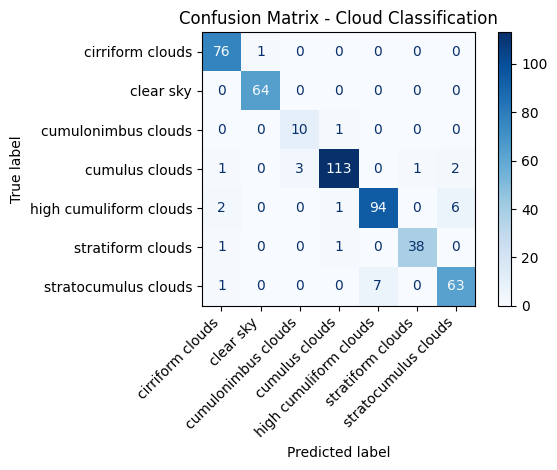

In [18]:
epochs_settings = [
        {"unfreeze": ["fc"], "lr": 1e-3, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer4", "fc"], "lr": 5e-4, "transform": aug_transforms, "num_epochs": 5},
        {"unfreeze": ["layer3", "layer4", "fc"], "lr": 1e-4, "transform": train_transforms, "num_epochs": 5},
        {"unfreeze": ["layer2", "layer3", "layer4", "fc"], "lr": 5e-5, "transform": aug_transforms, "num_epochs": 5},
        {"unfreeze": ["layer1", "layer2", "layer3", "layer4", "fc"], "lr": 1e-5, "transform": train_transforms, "num_epochs": 5}
    ]

model = train_model(model, combined_loader, test_loader, epochs_settings)

test_loss, test_acc, y_true, y_pred = eval_model(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {100 * test_acc:.4f}")

paint_confusion_matrix(y_true, y_pred)

**Вывод:** псевдолейблинг помог не утратить обобщающую способность на маленьком классе (10 из 11 правильных прогнозов), а также вернул точность на остальных классах, что помогло достичь максимальной точности за все прошлые обучения в 94.24